<a href="https://colab.research.google.com/github/Narusi/My-Projects/blob/master/Personal_Portfolio_Analysis%20v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install quandl

  Created wheel for yfinance: filename=yfinance-0.1.52-py2.py3-none-any.whl size=21997 sha256=3ba3ef98484356dbbca5d63a06bf8d6c66ea11f3ac62885b70cc1bdd1fe0e454
  Stored in directory: /root/.cache/pip/wheels/1b/9d/ce/929e851fc7d649cd962c177220ad985675785aa97c54df5714
Successfully built yfinance
     |████████████████████████████████| 61kB 4.5MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 2.3MB 14.2MB/s 
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=f1fd0d7fda0d6b74692b5b2701cdcb8f97a01b4d144f9cb5faaba7cb18315a61
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: more-itertools 8.0.2
    Uninstalling more-itertools-8.0.2:
      Successfully uninstalled more-itertools-8

In [0]:
import pandas as pd
import numpy as np

import yfinance as yf
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
positions = pd.DataFrame({
    'TICKER':['MCD','T','PFE','FB','MSFT'],
    'BUY DATE':['2019-10-29','2019-11-09','2019-12-02','2019-12-19','2019-12-19'],
    'BUY PRICE':[192.78,39.76,38.37,203.9,154.47],
    'POSITION':[0.3898,2.015,1.9672,0.36783,0.26542]
})
positions['BUY DATE'] = pd.to_datetime(positions['BUY DATE'])
positions

,TICKER,BUY DATE,BUY PRICE,POSITION
0,MCD,2019-10-29,192.78,0.38980
1,T,2019-11-09,39.76,2.01500
2,PFE,2019-12-02,38.37,1.96720
3,FB,2019-12-19,203.90,0.36783
4,MSFT,2019-12-19,154.47,0.26542


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


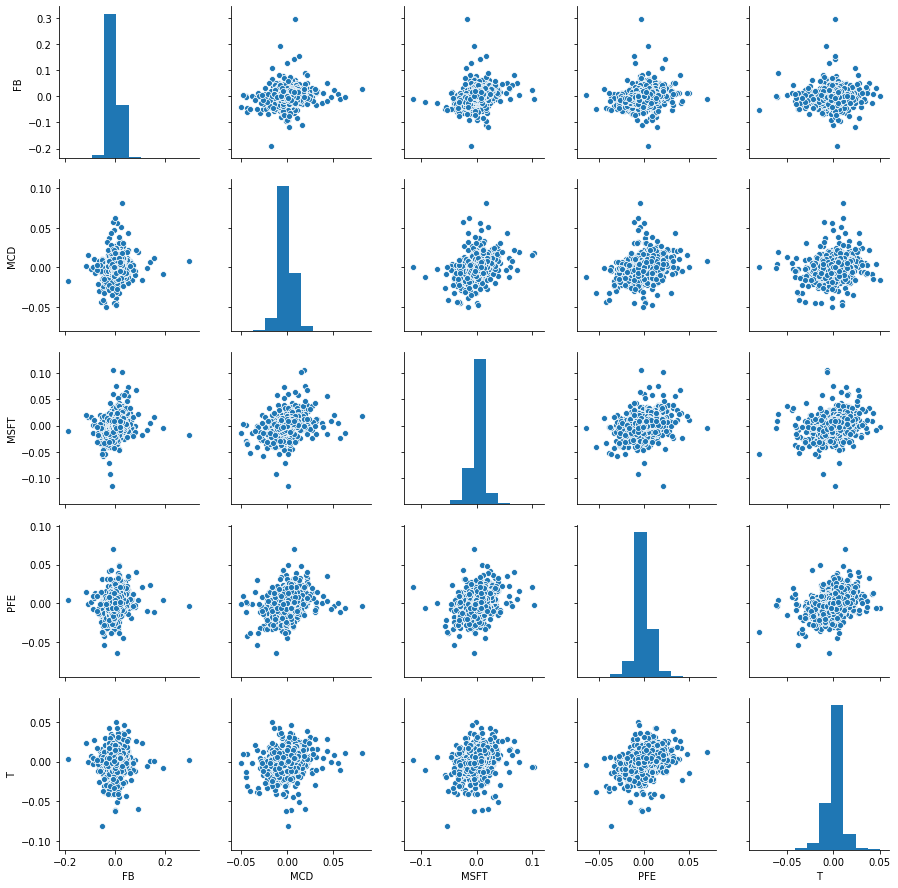

In [4]:
data = yf.download(positions['TICKER'].to_list()).resample('D').pad()
prices = data['Close'].fillna(method='ffill')

vixData = yf.download('^VIX').resample('D').pad()
vixPrices = vixData['Close'].fillna(method='ffill')

eeeData = yf.download('CEC.DE').resample('D').pad()
eee = eeeData['Close'].fillna(method='ffill')

#positions['BUY PRICE'] = 0.0
positions['MV'] = 0.0

ret = prices.pct_change().dropna()
wret = prices.pct_change(7).dropna()
mret = prices.pct_change(28).dropna()

log_ret = np.log(prices/prices.shift()).dropna()
mlog_ret = log_ret.rolling(28).sum()

sns.pairplot(ret)
plt.show();

In [5]:
for i in positions.index:
    ticker = positions.loc[i, 'TICKER']
    buyDate = positions.loc[i, 'BUY DATE']

    #positions.loc[i, 'BUY PRICE'] = prices.loc[buyDate, ticker]
    positions.loc[i, 'MV'] = positions.loc[i, 'POSITION'] * prices.iloc[-1][ticker]
#need to add div stats: yield, 5y avg yield, div growth years, expected div payment, div payment month
positions['WEIGHT'] = positions['MV']/positions['MV'].sum()
positions['RET'] = positions['MV'].div(positions['BUY PRICE'].mul(positions['POSITION'])).add(-1.0)

print('\nAUM: EUR',
      round(positions['MV'].sum(),2))

totalRet = positions['MV'].sum()/(positions['BUY PRICE'].mul(positions['POSITION']).sum()) - 1.
print('Total return: {}%'.format(round(100*totalRet,3)))
print('Expected 1Y return: {}%\n'.format(round(100*(np.dot(positions['WEIGHT'], 
                                                           log_ret.mean()[positions['TICKER']]) * 365),3)))

positions


AUM: EUR 350.23
Total return: 1.005%
Expected 1Y return: 11.737%



,TICKER,BUY DATE,BUY PRICE,POSITION,MV,WEIGHT,RET
0,MCD,2019-10-29,192.78,0.38980,76.860761,0.219460,0.022824
1,T,2019-11-09,39.76,2.01500,78.534622,0.224239,-0.019743
2,PFE,2019-12-02,38.37,1.96720,77.704400,0.221869,0.029450
3,FB,2019-12-19,203.90,0.36783,75.445612,0.215419,0.005934
4,MSFT,2019-12-19,154.47,0.26542,41.681555,0.119013,0.016637


In [0]:
tickers = positions['TICKER'].to_list()
weights = positions['WEIGHT']
covar = ret[tickers].cov()
portSeries = pd.Series(np.dot(mret[tickers], weights), index=mret.index).dropna()

In [7]:
portRet = np.dot(ret[tickers].mean(), weights)*365
portRisk = np.sqrt(np.dot(weights.T, np.dot(covar, weights))) * np.sqrt(365)
portVaR = portSeries.quantile(q=0.01)
portDTrisk = portSeries[portSeries < 0.0].std() * np.sqrt(12)

print('VaR (1%): {}%'.format(round(100*portVaR,3)))
print('Return: {}%'.format(round(100*portRet,3)))
print('Risk: {}%'.format(round(100*portRisk, 3)))
print('Downturn risk: {}%'.format(round(100*portDTrisk,3)))
print('Return/Risk:', round(portRet/portRisk,3))

VaR (1%): -6.644%
Return: 14.38%
Risk: 13.967%
Downturn risk: 6.44%
Return/Risk: 1.03


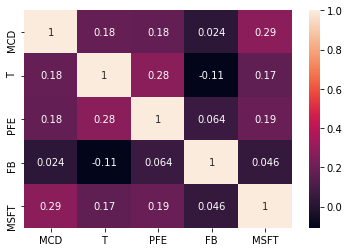

In [8]:
sns.heatmap(mret[tickers].corr(method='pearson'), annot=True)
plt.show();

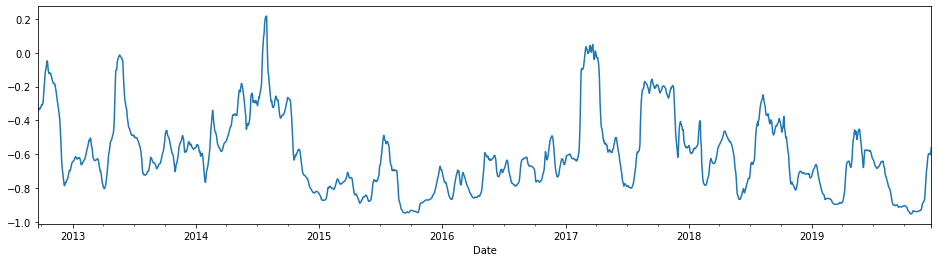

Correlation with VIX: -0.588
Expected 1Y return: 13.72%
Expected 1M return: 1.31% (2.36% STD, -514.35 Beta)



/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,RET,STD,Beta,PROB
-6,0.013702,0.022781,-6.094123,0.557312
-5,0.012290,0.024402,-4.606201,0.267457
-4,0.012333,0.025245,-2.939974,0.175231


In [9]:
vixCorr = vixPrices.pct_change(28).rolling(100).corr(portSeries).dropna()
vixCorr['2006':].plot(figsize=(16,4))
plt.show();

lower = -1.0
upper = 1.0

expOutcome = pd.DataFrame(index=list(range(-10,10)))
expOutcome['RET'] = 0.0
expOutcome['STD'] = 0.0
expOutcome['Beta'] = 0.0
expOutcome['PROB'] = 0.0

for i in range(-10,10):
    lower = i/10
    upper = lower + 0.1

    perRet = portSeries.loc[vixCorr[np.logical_and(vixCorr <= upper, vixCorr > lower)].index]
    vixRet = vixPrices.pct_change(28).loc[vixCorr[np.logical_and(vixCorr <= upper, vixCorr > lower)].index]

    expOutcome.loc[i, 'RET'] = perRet.mean()
    expOutcome.loc[i, 'STD'] = perRet.std()
    expOutcome.loc[i, 'Beta'] = float(np.cov(perRet, vixRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'PROB'] = len(perRet)/len(portSeries)    

print('Correlation with VIX:', round(vixPrices.pct_change(28).corr(portSeries),3))
expOutcome = expOutcome.fillna(0.0)

currState = int(vixCorr.iloc[-1]*10)
cSt = expOutcome.loc[[currState-1,currState,currState+1]]
cSt['PROB'] = cSt['PROB']/cSt['PROB'].sum()

print('Expected 1Y return: {}%'.format(round(100*expOutcome['RET'].mul(expOutcome['PROB']).sum()*12,2)))
print('Expected 1M return: {}% ({}% STD, {} Beta)\n'.format(round(100*cSt['RET'].mul(cSt['PROB']).sum(),2),
                                                          round(100*cSt['STD'].mul(cSt['PROB']).sum(),2),
                                                          round(100*cSt['Beta'].mul(cSt['PROB']).sum(),2)))
cSt

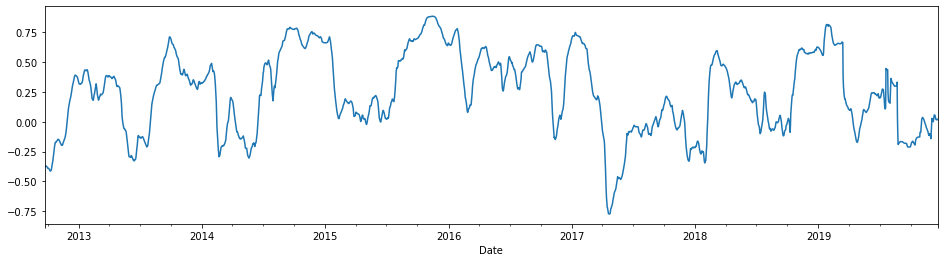

Correlation with Eastern Europe: 0.095
Expected 1Y return: 13.72%
Expected 1M return: 1.36% (2.31% STD, 279.97 Beta)



/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,RET,STD,Beta,PROB
-1,0.011950,0.020133,1.530223,0.333333
0,0.011235,0.021873,3.522741,0.340249
1,0.017857,0.027449,3.342281,0.326418


In [10]:
eeeCorr = eee.pct_change(28).rolling(100).corr(portSeries).dropna()
eeeCorr['2006':].plot(figsize=(16,4))
plt.show();

lower = -1.0
upper = 1.0

expOutcome = pd.DataFrame(index=list(range(-10,10)))
expOutcome['RET'] = 0.0
expOutcome['STD'] = 0.0
expOutcome['Beta'] = 0.0
expOutcome['PROB'] = 0.0

for i in range(-10,10):
    lower = i/10
    upper = lower + 0.1

    perRet = portSeries.loc[eeeCorr[np.logical_and(eeeCorr <= upper, eeeCorr > lower)].index]
    eeeRet = eee.pct_change(28).loc[eeeCorr[np.logical_and(eeeCorr <= upper, eeeCorr > lower)].index]

    expOutcome.loc[i, 'RET'] = perRet.mean()
    expOutcome.loc[i, 'STD'] = perRet.std()
    expOutcome.loc[i, 'Beta'] = float(np.cov(perRet, eeeRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'PROB'] = len(perRet)/len(portSeries)    

print('Correlation with Eastern Europe:', round(eee.pct_change(28).corr(portSeries),3))
expOutcome = expOutcome.fillna(0.0)

currState = int(eeeCorr.iloc[-1]*10)
cSt = expOutcome.loc[[currState-1,currState,currState+1]]
cSt['PROB'] = cSt['PROB']/cSt['PROB'].sum()

print('Expected 1Y return: {}%'.format(round(100*expOutcome['RET'].mul(expOutcome['PROB']).sum()*12,2)))
print('Expected 1M return: {}% ({}% STD, {} Beta)\n'.format(round(100*cSt['RET'].mul(cSt['PROB']).sum(),2),
                                                          round(100*cSt['STD'].mul(cSt['PROB']).sum(),2),
                                                          round(100*cSt['Beta'].mul(cSt['PROB']).sum(),2)))
cSt

In [11]:
expOutcome = pd.DataFrame(index=list(range(0,100,10)))
expOutcome['RET'] = 0.0
expOutcome['STD'] = 0.0
expOutcome['Beta EEE'] = 0.0
expOutcome['Beta VIX'] = 0.0
expOutcome['PROB'] = 0.0

stdRoll = portSeries.rolling(28).std()

for i in range(0,100,10):
    lower = i/100
    upper = lower + 0.1

    perRet = portSeries.loc[stdRoll[np.logical_and(stdRoll <= stdRoll.quantile(upper), stdRoll > stdRoll.quantile(lower))].index]
    eeeRet = eee.pct_change(28).loc[perRet.index]
    vixRet = vixPrices.pct_change(28).loc[perRet.index]

    expOutcome.loc[i, 'RET'] = perRet.mean()
    expOutcome.loc[i, 'STD'] = perRet.std()
    expOutcome.loc[i, 'Beta EEE'] = float(np.cov(perRet, eeeRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'Beta VIX'] = float(np.cov(perRet, vixRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'PROB'] = len(perRet)/len(portSeries)    

print('Correlation with Eastern Europe:', round(eee.pct_change(28).corr(portSeries),3))
expOutcome = expOutcome.fillna(0.0)

currState = int(eeeCorr.iloc[-1]*10)
cSt = expOutcome.loc[[currState-1,currState,currState+1]]
cSt['PROB'] = cSt['PROB']/cSt['PROB'].sum()

print('Expected 1Y return: {}%'.format(round(100*expOutcome['RET'].mul(expOutcome['PROB']).sum()*12,2)))
print('Expected 1M return: {}% ({}% STD)'.format(round(100*cSt['RET'].mul(cSt['PROB']).sum(),2),
                                                 round(100*cSt['STD'].mul(cSt['PROB']).sum(),2)))

print('Beta Europe: {}%\nBeta VIX: {}%\n'.format(round(100*cSt['Beta EEE'].mul(cSt['PROB']).sum(),2), 
                                                round(100*cSt['Beta VIX'].mul(cSt['PROB']).sum(),2)))
cSt
expOutcome

Correlation with Eastern Europe: 0.095
Expected 1Y return: 13.07%
Expected 1M return: 1.44% (1.43% STD)
Beta Europe: 194.84%
Beta VIX: -748.92%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,RET,STD,Beta EEE,Beta VIX,PROB
0,0.014388,0.014328,1.948378,-7.489204,0.098725
10,0.010167,0.018903,1.735643,-2.218367,0.099089
20,0.010476,0.018608,2.047904,-2.316702,0.099089
30,0.009003,0.024016,2.847680,-4.368517,0.098725
40,0.010810,0.024394,1.321211,-4.278412,0.099089
50,0.010751,0.023053,4.290654,-4.534251,0.099089
60,0.006786,0.027708,-0.069277,-6.373650,0.098725
70,0.012013,0.037824,0.525488,-6.244214,0.099089
80,0.011516,0.040288,1.544466,-6.386448,0.099089
90,0.014127,0.052311,1.381789,-5.259472,0.099089


In [12]:
expOutcome = pd.DataFrame(index=list(range(0,100,10)))
expOutcome['RET'] = 0.0
expOutcome['STD'] = 0.0
expOutcome['Beta EEE'] = 0.0
expOutcome['Beta VIX'] = 0.0
expOutcome['PROB'] = 0.0

corRoll = portSeries.rolling(28).corr(portSeries.shift(28))

for i in range(0,100,10):
    lower = i/100
    upper = lower + 0.1

    perRet = portSeries.loc[corRoll[np.logical_and(corRoll <= corRoll.quantile(upper), corRoll > corRoll.quantile(lower))].index]
    eeeRet = eee.pct_change(28).loc[perRet.index]
    vixRet = vixPrices.pct_change(28).loc[perRet.index]

    expOutcome.loc[i, 'RET'] = perRet.mean()
    expOutcome.loc[i, 'STD'] = perRet.std()
    expOutcome.loc[i, 'Beta EEE'] = float(np.cov(perRet, eeeRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'Beta VIX'] = float(np.cov(perRet, vixRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'PROB'] = len(perRet)/len(portSeries)    

print('Correlation with Eastern Europe:', round(eee.pct_change(28).corr(portSeries),3))
expOutcome = expOutcome.fillna(0.0)

currState = int(eeeCorr.iloc[-1]*10)
cSt = expOutcome.loc[[currState-1,currState,currState+1]]
cSt['PROB'] = cSt['PROB']/cSt['PROB'].sum()

print('Expected 1Y return: {}%'.format(round(100*expOutcome['RET'].mul(expOutcome['PROB']).sum()*12,2)))
print('Expected 1M return: {}% ({}% STD)'.format(round(100*cSt['RET'].mul(cSt['PROB']).sum(),2),
                                                 round(100*cSt['STD'].mul(cSt['PROB']).sum(),2)))

print('Beta Europe: {}%\nBeta VIX: {}%\n'.format(round(100*cSt['Beta EEE'].mul(cSt['PROB']).sum(),2), 
                                                round(100*cSt['Beta VIX'].mul(cSt['PROB']).sum(),2)))
cSt
expOutcome

Correlation with Eastern Europe: 0.095
Expected 1Y return: 13.35%
Expected 1M return: 0.91% (2.62% STD)
Beta Europe: 73.5%
Beta VIX: -437.94%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,RET,STD,Beta EEE,Beta VIX,PROB
0,0.009137,0.026161,0.735008,-4.379393,0.097632
10,0.010258,0.026601,0.214322,-5.294723,0.097996
20,0.014666,0.026306,1.739137,-4.906916,0.097996
30,0.011782,0.025950,1.523229,-5.306509,0.097996
40,0.008703,0.024524,0.791656,-6.220452,0.097996
50,0.010312,0.025828,6.971815,-7.429410,0.097996
60,0.009078,0.030138,2.969104,-7.302244,0.097996
70,0.014282,0.032484,1.102310,-5.641851,0.097996
80,0.008639,0.031495,1.378586,-6.174170,0.097996
90,0.016728,0.045649,-0.174832,-4.077159,0.097996
